             Park  AverageMonthlyCost  Area
0        ArcaAgua          191.434727   2.6
1          Avioso          755.192827  30.0
2       Biologico          783.394559  35.0
3          Cidade         2739.639696  69.9
4          Covelo          333.149158   7.7
5        Oriental          759.310327  15.0
6  PalacioCristal          649.940764   9.6
7        SaoRoque          325.173275   5.8
8           Varas          112.647676   1.7
Coefficient of Determination (R-squared): 0.90
Correlation Coefficient (R-value): 0.95
Predicted average monthly cost for a 55-hectare park: $1934.17 (95% CI: $1159.59 - $2708.74)


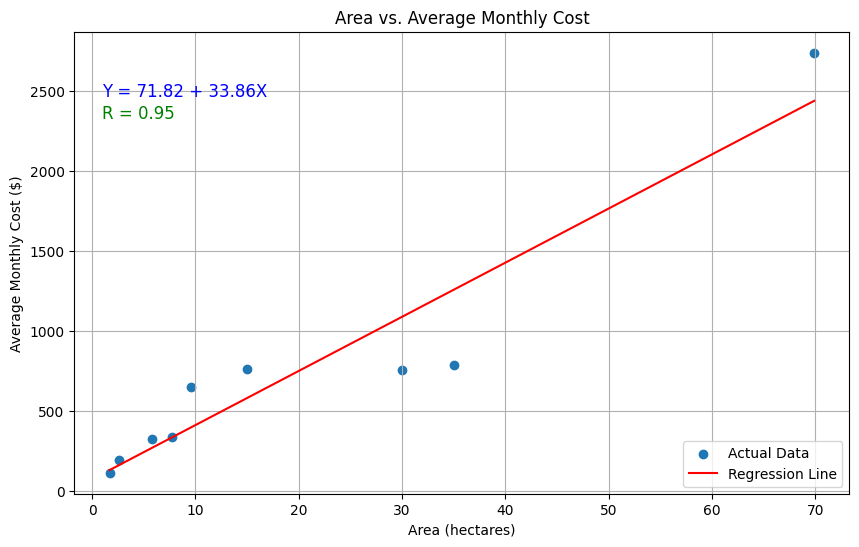

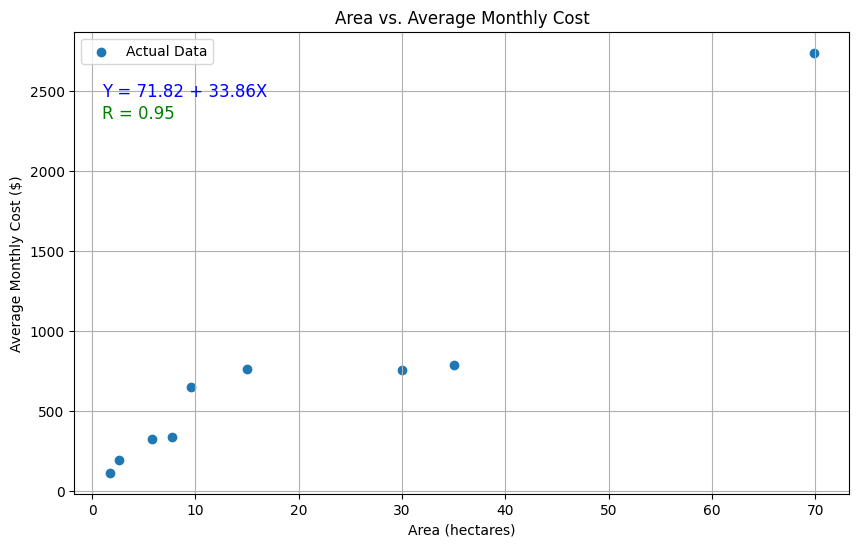

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

def load_data(file_path, delimiter=';'):
    try:
        return pd.read_csv(file_path, delimiter=delimiter)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def preprocess_area_data(area_data):
    area_data['Area'] = pd.to_numeric(area_data['Area'].str.replace(',', '.'), errors='coerce')
    return area_data

def calculate_monthly_consumption_and_cost(data):
    data['Consumption'] = pd.to_numeric(data['Consumption'].str.replace(',', '.'), errors='coerce')
    data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
    data['YearMonth'] = data['Date'].dt.to_period('M')
    monthly_data = data.groupby(['Park', 'YearMonth'])['Consumption'].sum().reset_index()
    monthly_data['MonthlyCost'] = (monthly_data['Consumption'].clip(upper=1000) * 0.7) + (
        (monthly_data['Consumption'] - 1000).clip(lower=0) * 0.7 * 1.15
    )
    return monthly_data

def compute_average_monthly_cost(monthly_data):
    return monthly_data.groupby('Park')['MonthlyCost'].mean().reset_index().rename(columns={'MonthlyCost': 'AverageMonthlyCost'})

def merge_data(water_cost_data, area_data):
    area_data = preprocess_area_data(area_data)
    return pd.merge(water_cost_data, area_data, on='Park')

def train_linear_regression_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def calculate_r_squared(model, X, y):
    r_squared = model.score(X, y)
    print(f'Coefficient of Determination (R-squared): {r_squared:.2f}')
    return r_squared

def calculate_r_value(X, y):
    correlation_matrix = np.corrcoef(X.flatten(), y)
    r_value = correlation_matrix[0, 1]
    print(f'Correlation Coefficient (R-value): {r_value:.2f}')
    return r_value

def plot_data_and_regression_line(X, y, y_pred, model, r_value, show_line=True):
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, label='Actual Data')
    if show_line:
        plt.plot(X, y_pred, color='red', label='Regression Line')
    plt.xlabel('Area (hectares)')
    plt.ylabel('Average Monthly Cost ($)')
    plt.title('Area vs. Average Monthly Cost')
    plt.legend()
    plt.grid(True)

    equation = f'Y = {model.intercept_:.2f} + {model.coef_[0]:.2f}X'
    plt.text(1, max(y) * 0.9, equation, fontsize=12, color='blue')
    plt.text(1, max(y) * 0.85, f'R = {r_value:.2f}', fontsize=12, color='green')
    plt.show()


def predict_new_park_cost_with_interval(model, new_area, X, y, confidence=0.95):
    new_area = np.array([[new_area]])
    predicted_cost = model.predict(new_area)
    n = len(X)
    mean_x = np.mean(X)
    se = np.sqrt((sum((y - model.predict(X))**2) / (n - 2)) * (1 + 1/n + (new_area - mean_x)**2 / sum((X - mean_x)**2)))
    t_value = stats.t.ppf((1 + confidence) / 2, n - 2)
    margin_of_error = t_value * se
    lower_bound = predicted_cost[0] - margin_of_error[0]
    upper_bound = predicted_cost[0] + margin_of_error[0]
    predicted_cost = predicted_cost.item()
    lower_bound = lower_bound.item()
    upper_bound = upper_bound.item()
    print(f'Predicted average monthly cost for a {new_area[0][0]}-hectare park: '
          f'${predicted_cost:.2f} (95% CI: ${lower_bound:.2f} - ${upper_bound:.2f})')

# Load data
water_data = load_data('water_consumption_updated.csv')
area_data = load_data('Area.csv')

if water_data is not None and area_data is not None:
    monthly_water_data = calculate_monthly_consumption_and_cost(water_data.copy())
    water_cost_data = compute_average_monthly_cost(monthly_water_data)
    merged_data = merge_data(water_cost_data, area_data)
    sorted_data = merged_data.sort_values(by='Area')
    X = sorted_data[['Area']].values.astype(float)
    y = sorted_data['AverageMonthlyCost'].values.astype(float)
    model = train_linear_regression_model(X, y)
    print(merged_data)
    r_squared = calculate_r_squared(model, X, y)
    r_value = calculate_r_value(X, y)
    predict_new_park_cost_with_interval(model, 55, X, y)
    y_pred = model.predict(X)

    # Plot with regression line
    plot_data_and_regression_line(X, y, y_pred, model, r_value, show_line=True)

    # Plot without regression line
    plot_data_and_regression_line(X, y, y_pred, model, r_value, show_line=False) 

## Análise de Resultados: Consumo de Água e Custos em Parques

Este estudo analisa a relação entre a área de um parque e seu custo médio mensal de água, utilizando técnicas de processamento de dados, regressão linear e visualização. 

**Cálculo do Consumo e Custo Mensal de Água:**

O primeiro passo foi garantir a consistência dos dados de consumo, convertendo-os para valores numéricos. Em seguida, o consumo mensal de água foi calculado para cada parque, agrupando os dados por parque e mês. O custo mensal foi obtido multiplicando o consumo por 0.7 €/m³. Para consumos acima de 1000 m³, um **acréscimo de 15%** foi aplicado ao custo, simulando variações tarifárias por volume.

**Cálculo do Custo Médio Mensal por Parque:** 

Para obter uma visão geral do custo ao longo do tempo, calculamos o custo médio mensal para cada parque. Isso foi feito agrupando os dados por parque e calculando a média dos custos mensais.

**Modelo de Regressão Linear:**

Para modelar a relação entre a área do parque e o custo médio mensal, construímos um modelo de regressão linear. A **área do parque (X)** foi a variável independente, e o **custo médio mensal (Y)** foi a variável dependente. A regressão linear se mostrou adequada devido à natureza contínua das variáveis e ao objetivo de modelar uma relação linear entre elas.

**Avaliação do Modelo:**

Para avaliar a qualidade do modelo, utilizamos o **Coeficiente de Correlação (R)** e o **Coeficiente de Determinação (R²)**. 

*   **Coeficiente de Correlação (R):** O valor de R foi calculado utilizando o método de Pearson, que mede a força e direção da relação linear entre duas variáveis. O valor obtido foi **R = 0.95**, indicando uma **forte correlação positiva** entre a área do parque e seu custo médio mensal de água.  Isso significa que, à medida que a área do parque aumenta, o custo médio mensal de água também tende a aumentar.

*   **Coeficiente de Determinação (R²):**  O R² mede a proporção da variabilidade na variável dependente (custo) que é explicada pela variável independente (área). O valor obtido foi **R² = 0.90**, o que significa que **90% da variabilidade nos custos mensais de água pode ser explicada pela área do parque**. Este valor elevado de R² indica um excelente ajuste do modelo aos dados, sugerindo que a área do parque é um bom preditor do custo mensal de água.

**Previsão para um Novo Parque e Análise do Gráfico:**

Com o modelo de regressão linear treinado, realizamos uma previsão do custo médio mensal de água para um novo parque com 55 hectares.  Para isso, utilizamos a equação da reta obtida pelo modelo: 

**y = 71.82 + 33.86x**

Onde:

*   **y:** representa o custo médio mensal de água (em €)
*   **x:** representa a área do parque (em hectares)

Substituindo x por 55 (área do novo parque), obtemos a previsão:

**y = 71.82 + 33.86 * 55 = 1934.12 €**

O gráfico de dispersão, que inclui a linha de regressão, ilustra essa relação.  Podemos observar que a linha de regressão se ajusta bem aos dados, capturando a tendência geral de aumento do custo com o aumento da área.  A equação da reta nos permite prever o custo para qualquer área de parque dentro do intervalo de dados analisado.

A previsão para o novo parque com 55 hectares resultou em um custo médio mensal estimado de 1934.17 €. No entanto, é importante considerar a incerteza associada a essa previsão.  Por isso, calculamos um intervalo de predição de 95%, que resultou em:

**(95% CI: 1159.59 € - 2708.74 €)**

Esse intervalo indica que temos 95% de confiança de que o custo real do novo parque estará entre 1159.59 € e 2708.74 €.  A amplitude do intervalo reflete a variabilidade nos dados e a incerteza inerente à extrapolação do modelo para uma área fora do intervalo de dados original.

**Ajuste Linear e Possíveis Melhorias:**

Embora o modelo apresente um bom ajuste geral aos dados, a análise visual do gráfico sugere que pode haver um ligeiro padrão não-linear na relação entre a área e o custo. Para confirmar essa hipótese, seria necessário um estudo mais aprofundado, utilizando métodos estatísticos para avaliar a linearidade do modelo. Caso a não-linearidade seja confirmada, podemos explorar modelos de regressão não-linear para aprimorar a precisão das previsões.

**Conclusão:**

A análise estatística, utilizando regressão linear, demonstrou uma forte relação positiva entre a área do parque e o custo médio mensal de água. O modelo construído apresentou um excelente ajuste aos dados, comprovado pelo alto valor de R².  Com base nesse modelo, podemos prever com confiança os custos de água para novos parques, auxiliando na tomada de decisões estratégicas relacionadas ao planejamento e gestão de recursos hídricos.  No entanto, a investigação de possíveis ajustes não-lineares pode aprimorar ainda mais a precisão do modelo.